# Load data

In [1]:
import os
import gc
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import json
import ast
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
sns.set_theme(style="darkgrid", palette="deep")

In [18]:
output_dir = os.getcwd()+'/gpt_inference/gpt-4.1/'
batchfile_dir = os.getcwd()+'/data/gpt-batchfiles/'
n_trials = 2

# Data Statistics

In [117]:
with open(f"{os.getcwd()}/data/author_to_subID_to_inst.pkl", "rb") as f:
    author_to_subID_to_inst = pickle.load(f)

In [107]:
df = pd.read_csv(f"{os.getcwd()}/data/data_active_authorExt_withAbstValues.tsv", sep='\t')

print(len(df), len(list(set(df['subID'].tolist()))))

53280 17432


In [35]:
len(list(set(df['author'].tolist())))

226

In [36]:
cnt = Counter()
cnt.update(df['author'].tolist())
cnt_s = sorted(cnt.items(), key=lambda x:x[1], reverse=True)
print(cnt_s[:5])
print(cnt_s[-5:])

[('iluvcats17', 2870), ('ComprehensiveBand586', 2721), ('NoApollonia', 2631), ('holisarcasm', 2420), ('mm172', 2320)]
[('jcaashby', 100), ('AggravatingPatient18', 100), ('sashaopinion', 100), ('Status-Pattern7539', 100), ('nebunala4328', 100)]


In [40]:
AUTHORS = [elem[0] for elem in cnt_s][:100]

In [39]:
sum(df['judgment'].tolist()), len(df['judgment'].tolist()), len(df['judgment'].tolist())-sum(df['judgment'].tolist())

(38365, 53280, 14915)

In [44]:
author_to_judgment = {_author:[] for _author in AUTHORS}
for _author, _judgment in zip(df['author'].tolist(), df['judgment'].tolist()):
    if _author not in author_to_judgment:
        continue
    author_to_judgment[_author].append(_judgment)
author_to_judgmentPatterns = {_author:[] for _author in AUTHORS}
for _author in author_to_judgment:
    author_to_judgmentPatterns[_author] = abs(0.5-sum(author_to_judgment[_author])/len(author_to_judgment[_author]))
author_to_judgmentPatterns_s = sorted(author_to_judgmentPatterns.items(), key=lambda x:x[1], reverse=True)

In [46]:
author_to_judgmentPatterns_s[:10]

[('teresajs', 0.4553264604810997),
 ('G8RTOAD', 0.4521739130434783),
 ('No_Proposal7628', 0.44053208137715183),
 ('Algebralovr', 0.41555555555555557),
 ('CMSkye', 0.41162790697674423),
 ('RavenBlueEyes84', 0.40963855421686746),
 ('seba_make', 0.4019607843137255),
 ('slendermanismydad', 0.4017857142857143),
 ('meifahs_musungs', 0.3975609756097561),
 ('Professional_Duck564', 0.3907103825136612)]

In [47]:
for _author_inst in author_to_judgmentPatterns_s[:3]:
    _author = _author_inst[0]
    print(_author, len(author_to_judgment[_author]), len(author_to_judgment[_author])-sum(author_to_judgment[_author]))

teresajs 1746 78
G8RTOAD 230 11
No_Proposal7628 639 38


In [49]:
subID_to_authors = {}
for _author, _subID in zip(df['author'].tolist(), df['subID'].tolist()):
    if _author not in AUTHORS:
        continue
    if _subID not in subID_to_authors:
        subID_to_authors[_subID] = []
    subID_to_authors[_subID].append(_author)
subID_to_author_len = []
for _subID in subID_to_authors:
    subID_to_author_len.append(len(subID_to_authors[_subID]))
print(np.mean(subID_to_author_len), np.std(subID_to_author_len), np.max(subID_to_author_len), np.min(subID_to_author_len), np.median(subID_to_author_len))


2.221489215236347 1.9337618662216722 16 1 1.0


## Retrieval

In [116]:
_inst0 = df[df['subID']=='e71h54'].iloc[0]
print(_inst0['author'])
print(_inst0['comment'], _inst0['judgment'])
print(json.loads(_inst0['comm_val'].replace("```json","").replace("```",""))['Winning Values'])

WebbieVanderquack
If you hadn't asked, she probably would have offered. But you shouldn't have asked. You don't have to cancel, just let her stay in what is effectively her home while the poker happens. You're not a bachelor anymore, and you can't kick your SO out whenever you want to be one. 0
['Shared living arrangements > Personal space', "Prioritizing partner's comfort > Socializing with friends", 'Expectations of compromise > Individual preferences']


In [115]:
_inst1 = df[df['subID']=='e71h54'].iloc[1]
print(_inst1['author'])
print(_inst1['comment'], _inst1['judgment'])
print(json.loads(_inst1['comm_val'].replace("```json","").replace("```",""))['Winning Values'])

NoApollonia
The apartment is not just yours, it's also hers. You are essentially asking her to leave on Christmas evening and not come back until the next day? Of course you're the asshole. Why can't she be in the apartment while you all play poker? Why not play poker somewhere else? I'm married and if my husband proposed this, my first response would honestly to start laughing (as in at him for such an unreasonable request) and tell him to go somewhere else if he doesn't want me around that evening. 0
['Shared living arrangements > Personal space', "Prioritizing partner's comfort > Socializing with friends"]


In [114]:
_inst2 = df[df['subID']=='e71h54'].iloc[2]
print(_inst2['author'])
print(_inst2['comment'], _inst2['judgment'])
print(json.loads(_inst2['comm_val'].replace("```json","").replace("```",""))['Winning Values'])

iluvcats17
it is fine to ask and ok if she declines. I would still host it though. She can then decide if she wants to be kept awake or go elsewhere when she knows it is happening. If it is only once a year with friends from out of town so I would not cancel it. 1
["Socializing with friends > Prioritizing partner's comfort", 'Individual preferences > Expectations of compromise']


In [82]:
subID_to_value = {}
for _subID, _value in zip(df.subID.tolist(), df.situ_val_patterns.tolist()):
    subID_to_value[_subID] = _value

In [92]:
subID_to_value['e71h54']

"Family Tradition Importance vs. Friendship Dynamics and Changes\nAutonomy and Personal Space vs. Shared Space Dynamics\nSocial Relationships and Obligations vs. Partner's Emotional Needs\nAcceptance of Uncertainty and Flexibility vs. Lifestyle Choices and Preferences"

In [66]:
subID_to_title, subID_to_selftext = {}, {}
for _subID, _title, _selftext in zip(df.subID.tolist(), df.title.tolist(), df.selftext.tolist()):
    subID_to_title[_subID] = _title 
    subID_to_selftext[_subID] =  _selftext

In [73]:
with open(f"{os.getcwd()}/data/ID_to_closest_bySituation.pkl", "rb") as f:
    ID_to_closest = pickle.load(f)
with open(f'{os.getcwd()}/embedding/Situation_text-embedding-3-large.pkl', 'rb') as f:
    situ_dist_data = pickle.load(f)
subID_to_situIndex, situIndex_to_subID = {}, {}
for idx, elem in enumerate(situ_dist_data['ID']):
    subID_to_situIndex[elem] = idx
    situIndex_to_subID[idx] = elem

In [90]:
closest_subID = [situIndex_to_subID[elem[0]] for elem in ID_to_closest['e71h54###NoApollonia']][:5]
for _subID in closest_subID:
    print(_subID, subID_to_title[_subID])
    print(subID_to_value[_subID])
    print('==')

eqgy8f not wanting to move out from a shared flat for 1-2 nights because my SO wants to invite her parents?
Personal Boundaries and Well-being vs. Family Dynamics Exploration
Shared Space Dynamics vs. Family Tradition Importance
Individual Autonomy Emphasis vs. Support Systems and Community
Cultural Values of Generosity vs. Practicality in Daily Life
==
dgcqsi I stayed overnight at my girlfriends house despite her roomate saying no?
Personal Comfort Importance vs. Emotional Aspects and Security
Boundary Awareness and Respect vs. Recognition and Acknowledgment
Trust in Relationships vs. Landlord-Tenant Dynamics
Individual Autonomy Emphasis vs. Cohabitation Challenges
==
btyddr I got a hotel room for me and my partner, since my parents won't let us sleep in the same room?
Traditional Family Values vs. Cultural Expectations and Norms
Faith and Spirituality Focus vs. Individual Autonomy Emphasis
Parenting Authority Dynamics vs. Adult Responsibilities and Perspectives
Comfort in Relationshi

In [87]:
closest_subID = [situIndex_to_subID[elem[0]] for elem in ID_to_closest['e71h54###iluvcats17']][:5]
for _subID in closest_subID:
    print(_subID, subID_to_title[_subID])
    print(subID_to_value[_subID])
    print('==')

jbdtyd asking my girlfriend to move back with her parents?
Cleanliness Expectations vs. Personal Comfort Importance
Independence in Personal Life vs. Collective Responsibility and Support
Professional Standards vs. Cultural Influences on Parenting
Behavioral Expectations vs. Perception of Intervention Dynamics
Host Control and Limitations vs. Personal Boundaries and Well-being
==
cuwikg not wanting to leave a group hangout early with my girlfriend?
Personal Enjoyment and Indulgence vs. Commitment and Responsibility in Relationships
Fear of Social Relationships vs. Social Relationships and Obligations
Independence in Personal Life vs. Dependency and Agency
Honesty and Truthfulness vs. Social Norms and Expectations
==
eagyli I cancel my Airbnb because she's inviting her parents?
Social Norms and Expectations vs. Personal Comfort Importance
Social and Shared Enjoyment vs. Extended Family Involvement
Adult Responsibilities and Perspectives vs. Parental Responsibility and Care
Expectations 

In [88]:
closest_subID = [situIndex_to_subID[elem[0]] for elem in ID_to_closest['e71h54###WebbieVanderquack']][:5]
for _subID in closest_subID:
    print(_subID, subID_to_title[_subID])
    print(subID_to_value[_subID])
    print('==')

cutgko getting at my girlfriend for not being supportive
Supportive Relationships vs. Perception of Criticism
Personal Enjoyment and Indulgence vs. Consumer Behavior and Spending
Desire for Closeness vs. Independence in Personal Life
Respect for Privacy Boundaries vs. Lack of Connection
==
jfsrou telling my wife I don’t want her to have a sleepover at her friends house?
Freedom of Choice vs. Commitment to Family Traditions
Personal Enjoyment and Indulgence vs. Spousal Support Dynamics
Social Relationships and Obligations vs. Parental Responsibility and Care
==
n9s9ne inviting a friend while my GF has an exam?
Freedom of Choice vs. Expectations in Partnerships
Educational Responsibility and Commitment vs. Social Relationships and Obligations
Consideration and Support vs. Individual Autonomy Emphasis
Perception of Intervention Dynamics vs. Need for Validation
==
dp881l not inviting my husband's friend's new partner for an intimate dinner?
Comfort in Relationships vs. Social Relationships

In [94]:
with open(f"{os.getcwd()}/data/ID_to_closest_byAbstValue.pkl", "rb") as f:
    ID_to_closest2 = pickle.load(f)
with open(f'{os.getcwd()}/embedding/AbstValue_text-embedding-3-large.pkl', 'rb') as f:
    situ_dist_data2 = pickle.load(f)
    
situIndex_to_subID2 = {}
for idx, elem in enumerate(situ_dist_data2['ID']):
    situIndex_to_subID2[idx] = elem

In [128]:
# _inst2 = df[df['subID']=='e71h54'].iloc[2]
_author = _inst2['author']
print(_author)
print(_inst2['comment'], _inst2['judgment'])
print("\n".join(json.loads(_inst2['comm_val'].replace("```json","").replace("```",""))['Winning Values']))
print("====")
closest_subID2 = [situIndex_to_subID2[elem[0]].split('###')[0] for elem in ID_to_closest2[f'e71h54###{_author}']][:10]
for _subID in closest_subID2:
    print(subID_to_title[_subID])
    print(author_to_subID_to_inst[_author][_subID]['abst_value'])
    # print(subID_to_value[_subID])
    print('--')

iluvcats17
it is fine to ask and ok if she declines. I would still host it though. She can then decide if she wants to be kept awake or go elsewhere when she knows it is happening. If it is only once a year with friends from out of town so I would not cancel it. 1
Socializing with friends > Prioritizing partner's comfort
Individual preferences > Expectations of compromise
====
moving out because my girlfriend moved her mom in?
Autonomy and Personal Space > Family Dynamics and Loyalty
Boundary Awareness and Respect > Communication and Miscommunication
--
being upset that my roommate's boyfriend hangs out in our room everyday/night?
Consideration and Support > Satisfaction and Enjoyment
Communication and Expression > Personal Comfort Importance
Autonomy and Personal Space > Relationship Dynamics and Interdependence
--
not wanting to take my partner's last name even though he does so much for me?
Individual Autonomy Emphasis > Interpersonal Relationship Discomfort
Cultural Heritage and Id

In [126]:
# _inst2 = df[df['subID']=='e71h54'].iloc[2]
_author = _inst1['author']
print(_author)
print(_inst1['comment'], _inst1['judgment'])
print("\n".join(json.loads(_inst1['comm_val'].replace("```json","").replace("```",""))['Winning Values']))
print("====")
closest_subID2 = [situIndex_to_subID2[elem[0]].split('###')[0] for elem in ID_to_closest2[f'e71h54###{_author}']][:5]
for _subID in closest_subID2:
    print(subID_to_title[_subID])
    print(author_to_subID_to_inst[_author][_subID]['abst_value'])
    # print(subID_to_value[_subID])
    print('--')

NoApollonia
The apartment is not just yours, it's also hers. You are essentially asking her to leave on Christmas evening and not come back until the next day? Of course you're the asshole. Why can't she be in the apartment while you all play poker? Why not play poker somewhere else? I'm married and if my husband proposed this, my first response would honestly to start laughing (as in at him for such an unreasonable request) and tell him to go somewhere else if he doesn't want me around that evening. 0
Shared living arrangements > Personal space
Prioritizing partner's comfort > Socializing with friends
====
staying in a hotel because my parents refuse to let me sleep in the same bed as my partner when we visit.
Inclusion and Acceptance > Betrayal and Trust Issues
Individual Autonomy Emphasis > Social Expectations of Family
--
not accommodating one staff member over the rest of my staff?
Lifestyle Choices and Preferences > Balancing Individual Needs
Family Tradition Importance > Inclusi

In [127]:
# _inst2 = df[df['subID']=='e71h54'].iloc[2]
_author = _inst0['author']
print(_author)
print(_inst0['comment'], _inst0['judgment'])
print("\n".join(json.loads(_inst0['comm_val'].replace("```json","").replace("```",""))['Winning Values']))
print("====")
closest_subID2 = [situIndex_to_subID2[elem[0]].split('###')[0] for elem in ID_to_closest2[f'e71h54###{_author}']][:5]
for _subID in closest_subID2:
    print(subID_to_title[_subID])
    print(author_to_subID_to_inst[_author][_subID]['abst_value'])
    # print(subID_to_value[_subID])
    print('--')

WebbieVanderquack
If you hadn't asked, she probably would have offered. But you shouldn't have asked. You don't have to cancel, just let her stay in what is effectively her home while the poker happens. You're not a bachelor anymore, and you can't kick your SO out whenever you want to be one. 0
Shared living arrangements > Personal space
Prioritizing partner's comfort > Socializing with friends
Expectations of compromise > Individual preferences
====
vetoing naming a future child after my partner, even though that's a tradition in his family?
Self-Identity and Acceptance > Cultural Heritage and Identity
Individual Autonomy > Family Tradition Importance
--
telling my friend we may as well just watch something else after she looked up all the spoilers for a show we planned to watch together? (there are no spoilers in the story, I promise)
Interpersonal Dynamics and Frustrations > Commitment and Support
Informal Attitudes and Behaviors > Desire for Simplicity and Ease
--
not including one

# Author attributes

In [3]:
with open(f"{os.getcwd()}//data/author_to_controversialIndex_byRedditor.pkl", "rb") as f:
    author_to_testHardIdx = pickle.load(f)
author_cnt = {_author:len(author_to_testHardIdx[_author]) for _author in author_to_testHardIdx}
author_cnt = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)
AUTHORS = [elem[0] for elem in author_cnt[:100]]

"""
author_to_controversialRatio:
- closer to 0 -> tend to participate on non-controversial situations
- closer to 1 -> tend to participate on more controversial situations
"""
author_to_controversialRatio = {} # 
for _author in author_to_testHardIdx:
    author_to_controversialRatio[_author] = sum(author_to_testHardIdx[_author])/len(author_to_testHardIdx[_author])

In [4]:
"""
author_to_judgmentPatterns:
- closer to 0 -> tend to say 'not acceptable' more
- closer to 1 -> tend to say 'acceptable' more
- closer to 0.5 -> balanced judgment
"""

with open(f"{os.getcwd()}//data/subID_to_votes.pkl", "rb") as f:
    subID_to_votes = pickle.load(f)
with open(f"{os.getcwd()}//data/author_to_subID_to_inst.pkl", "rb") as f:
    author_to_subID_to_inst = pickle.load(f)
    
author_to_judgmentPatterns, author_to_numInst, author_to_numInst_log = {}, {}, {}
for _author in author_to_subID_to_inst:
    _patterns = []
    for _subID in author_to_subID_to_inst[_author]:
        _patterns.append(author_to_subID_to_inst[_author][_subID]['judgment'])
    author_to_judgmentPatterns[_author] = 1-abs(0.5-sum(_patterns)/len(_patterns))*2
    author_to_numInst[_author] = len(_patterns)
    author_to_numInst_log[_author] = np.log(len(_patterns))

In [5]:
"""
author_to_majorityRatio:
- closer to 0 -> tend to align with majority 
- closer to 1 -> tend to be outlier
"""

author_to_majorityRatio = {}
for _author in author_to_subID_to_inst:
    _tendencies = []
    for _subID in author_to_subID_to_inst[_author]:
        _val = sum(subID_to_votes[_subID])/len(subID_to_votes[_subID])
        _majority = round(_val)
        _judgment = author_to_subID_to_inst[_author][_subID]['judgment']
        
        if _majority != _judgment and (_val < 0.3 or _val > 0.7):
            _tendencies.append(1)
        else:
            _tendencies.append(0)

    author_to_majorityRatio[_author] = sum(_tendencies)/len(_tendencies)

In [6]:
author_to_numInst_judgmentPatterns = {}
for _author in author_to_subID_to_inst:
    author_to_numInst_judgmentPatterns[_author] = author_to_numInst_log[_author] * author_to_judgmentPatterns[_author]

In [7]:
from sklearn.preprocessing import QuantileTransformer

def flatten_attr_dict(attr_dict, n_quantiles=10):
    _authors, _list = [], []
    for _author in attr_dict:
        _authors.append(_author)
        _list.append(attr_dict[_author])
    quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=n_quantiles)
    data = np.array(_list).reshape(-1, 1)
    transformed_data = [elem[0] for elem in quantile_transformer.fit_transform(data)]
    return_dict = {}
    for _author, _mapped_data in zip(_authors, transformed_data):
        return_dict[_author] = _mapped_data
    return return_dict

author_to_numInst_flat = flatten_attr_dict(author_to_numInst)
author_to_majorityRatio_flat = flatten_attr_dict(author_to_majorityRatio)
author_to_controversialRatio_flat = flatten_attr_dict(author_to_controversialRatio)
author_to_judgmentPatterns_flat = flatten_attr_dict(author_to_judgmentPatterns)
author_to_numInst_judgmentPatterns_flat = flatten_attr_dict(author_to_numInst_judgmentPatterns)

In [8]:
# Define user "difficultiness" in a fine-tuned models' view

thrs = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
# author_data_sorted = sorted(author_to_numInst_judgmentPatterns.items(), key=lambda x:x[1], reverse=True)
author_data_sorted = sorted(author_to_numInst.items(), key=lambda x:x[1], reverse=True)
author_data_sorted = [elem for elem in author_data_sorted if elem[0] in AUTHORS]
num_authors = len(author_data_sorted)

top_thr_to_authors, bottom_thr_to_authors = {}, {}
for _thr in thrs:
    top_thr_to_authors[_thr] = [elem[0] for elem in author_data_sorted][:int(num_authors*_thr)]
    bottom_thr_to_authors[_thr] = [elem[0] for elem in author_data_sorted[::-1]][:int(num_authors*_thr)]
    

In [24]:
def convert_pred_to_digit(labels, preds):
    pred_digits = []
    for _label, _pred in zip(labels, preds):
        if _pred.strip().isdigit():
            pred_digits.append(int(_pred.strip()))
        else:
            if '1' in _pred and '0' not in _pred:
                pred_digits.append(1)
            elif '0' in _pred and '1' not in _pred:
                pred_digits.append(0)
            elif 'acceptable' in _pred.lower() and 'unacceptable' not in _pred.lower():
                pred_digits.append(1)
            elif 'unacceptable' in _pred.lower() and 'Acceptable' not in _pred:
                pred_digits.append(0)
            else:
                pred_digits.append(1-_label)
            
    return pred_digits

In [25]:
def _return_df(_filename, id_to_gold):
    df = pd.read_json(output_dir+_filename, lines=True)
    df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
    df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
    df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])
    _golds = df['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
    _preds = df['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
    _preds = convert_pred_to_digit(_golds, _preds)
    df['gold'] = _golds
    df['pred'] = _preds

    return df

In [26]:
with open(batchfile_dir+"gpt-4.1_5shots_SituationwithSelftext_Comment__gold.pkl", "rb") as f:
    id_to_gold = pickle.load(f)
df_situ = _return_df("gpt-4.1_5shots_SituationwithSelftext_Comment.jsonl", id_to_gold)
with open(f"{os.getcwd()}/data/ID_to_closest_bySituation.pkl", "rb") as f:
    ID_to_closest = pickle.load(f)

<Axes: xlabel='score', ylabel='dist'>

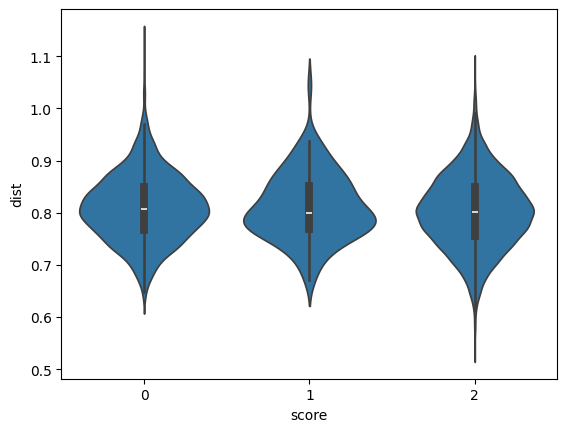

In [33]:
from _00_data_loader import get_data_split_author


author_to_data = {_author:{} for _author in AUTHORS}
for _author in AUTHORS:
    df = df_situ[df_situ['author']==_author]
    _, _, _test_set = get_data_split_author('/data/byRedditor', _author, 100000, 100000, 100000, return_dict=False)
    for i in range(n_trials):
        minidf = df[df['trial']==i]
        for idx, (item, _pred, _gold) in enumerate(zip(_test_set, minidf['pred'].tolist(), minidf['gold'].tolist())):
            avg_dist = np.mean([elem[1] for elem in ID_to_closest[f'{item["subID"]}###{_author}']][:5])
            if idx not in author_to_data[_author]:
                author_to_data[_author][idx] = {'dist':0, 'score':0}
            author_to_data[_author][idx]['dist'] = avg_dist
            author_to_data[_author][idx]['score'] += int(_pred==_gold)
            # _dict['dist'].append(avg_dist)
            # _dict['score'].append(_pred==_gold)
_dict = {'dist':[], 'score':[]}
for _author in author_to_data:
    for idx in author_to_data[_author]:
        _dict['dist'].append(author_to_data[_author][idx]['dist'])
        _dict['score'].append(author_to_data[_author][idx]['score'])
            
df_viz = pd.DataFrame(data=_dict)
g = sns.violinplot(data=df_viz, x="score", y="dist",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

In [23]:
df_viz['score']

0        False
1        False
2        False
3        False
4        False
         ...  
22987    False
22988    False
22989    False
22990    False
22991    False
Name: score, Length: 22992, dtype: bool

<Axes: xlabel='Num Instances (Log)', ylabel='Avg Dist'>

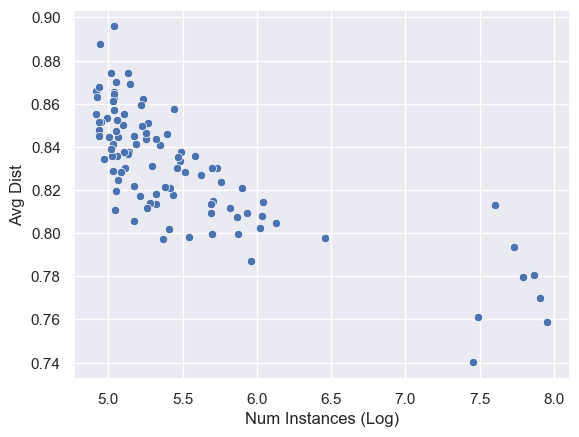

In [104]:
from _00_data_loader import get_data_split_author


author_to_data = {_author:{} for _author in AUTHORS}
for _author in AUTHORS:
    df = df_situ[df_situ['author']==_author]
    _, _, _test_set = get_data_split_author('/data/byRedditor', _author, 100000, 100000, 100000, return_dict=False)
    for i in range(n_trials):
        minidf = df[df['trial']==i]
        for idx, (item, _pred, _gold) in enumerate(zip(_test_set, minidf['pred'].tolist(), minidf['gold'].tolist())):
            avg_dist = np.mean([elem[1] for elem in ID_to_closest[f'{item["subID"]}###{_author}']][:5])
            if idx not in author_to_data[_author]:
                author_to_data[_author][idx] = {'dist':0, 'score':0}
            author_to_data[_author][idx]['dist'] = avg_dist
            author_to_data[_author][idx]['score'] += int(_pred==_gold)
            # _dict['dist'].append(avg_dist)
            # _dict['score'].append(_pred==_gold)
_dict = {'Avg Dist':[], 'Num Instances (Log)':[]}
for _author in author_to_data:
    _dists = []
    for idx in author_to_data[_author]:
        _dists.append(author_to_data[_author][idx]['dist'])
    _dict['Avg Dist'].append(np.mean(_dists))
    _dict['Num Instances (Log)'].append(author_to_numInst_log[_author])
        # _dict['dist'].append(author_to_data[_author][idx]['dist'])
        # _dict['score'].append(author_to_data[_author][idx]['score'])
            
df_viz = pd.DataFrame(data=_dict)
g = sns.scatterplot(data=df_viz, x="Num Instances (Log)", y="Avg Dist",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

In [105]:
g.figure.savefig(f'{os.getcwd()}/diagram/NumInstLog_to_AvgDist.png', bbox_inches='tight')

# Error Analysis
- For incorrect test situation
- Check the true value trade-off (from their comment)
- Check the overall win-rate of the conflict